<a href="https://colab.research.google.com/github/pedrosof/CardioAI--Classificador/blob/main/classificador_risco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificador de risco clínico

Este notebook foi preparado para execução no **Google Colab**. Ele monta o Google Drive, acessa a pasta `My Drive/CardioAI/Classificador/data` para ler o arquivo `mapa_risco.csv` e salva relatórios e gráficos em `My Drive/CardioAI/Classificador/reports`.

Estrutura esperada no Drive:
```
MyDrive/
└── CardioAI/
    └── Classificador/
        ├── data/
        │   └── mapa_risco.csv
        └── reports/
```

In [12]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# 1) Definir caminhos
import os
base_dir = '/content/drive/MyDrive/CardioAI/Classificador'
data_dir = os.path.join(base_dir, 'data')
reports_dir = os.path.join(base_dir, 'reports')

os.makedirs(data_dir, exist_ok=True)
os.makedirs(reports_dir, exist_ok=True)

CSV_PATH = os.path.join(data_dir, 'mapa_risco.csv')
assert os.path.exists(CSV_PATH), f"Arquivo não encontrado: {CSV_PATH}"

In [ ]:
# 2) Ler base de dados e exibir informações
import pandas as pd

df = pd.read_csv(CSV_PATH)
print('Dimensões:', df.shape)
print('\nAmostra das primeiras linhas:')
display(df.head())
print('\nDistribuição de rótulos:')
display(df['situacao'].value_counts())

Dimensões: (51, 2)

Amostra das primeiras linhas:


,frase,situacao
0,sinto dor no peito e falta de ar,alto risco
1,tive um leve incômodo nas costas,baixo risco
2,sinto palpitações e tontura constante,alto risco
3,acordei com dor de cabeça leve,baixo risco
4,tenho febre alta e calafrios,médio risco



Distribuição de rótulos:


,count
situacao,
médio risco,20
alto risco,18
baixo risco,13


In [ ]:
# 3) Divisão treino/teste e TF-IDF
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(
    df['frase'], df['situacao'], test_size=0.2, random_state=42, stratify=df['situacao']
)

vectorizer = TfidfVectorizer(
    stop_words=None,
    strip_accents='unicode',
    lowercase=True,
    ngram_range=(1, 2)
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print('TF-IDF treino:', X_train_tfidf.shape)
print('TF-IDF teste:', X_test_tfidf.shape)

TF-IDF treino: (40, 311)
TF-IDF teste: (11, 311)


In [ ]:
# 4) Treinamento do modelo (Regressão Logística)
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=200)
model.fit(X_train_tfidf, y_train)
print('Modelo treinado com sucesso.')

Modelo treinado com sucesso.


In [ ]:
# 5) Avaliação e relatório
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test_tfidf)
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Acurácia: {acc:.2%}\n')
print('Relatório de Classificação:\n', report)

# Salvar relatório
relatorio_path = os.path.join(reports_dir, 'relatorio_classificacao.txt')
with open(relatorio_path, 'w') as f:
    f.write(f'Acurácia: {acc:.2%}\n\n')
    f.write(report)
print(f'Relatório salvo em: {relatorio_path}')

Acurácia: 54.55%

Relatório de Classificação:
               precision    recall  f1-score   support

  alto risco       0.50      0.50      0.50         4
 baixo risco       1.00      0.33      0.50         3
 médio risco       0.50      0.75      0.60         4

    accuracy                           0.55        11
   macro avg       0.67      0.53      0.53        11
weighted avg       0.64      0.55      0.54        11

Relatório salvo em: /content/drive/MyDrive/CardioAI/Classificador/reports/relatorio_classificacao.txt


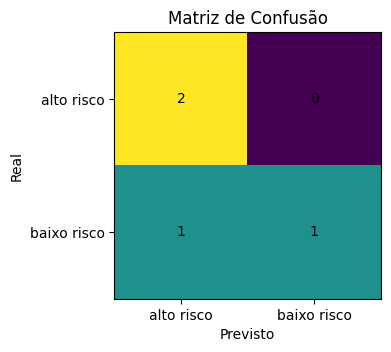

Gráfico salvo em: /content/drive/MyDrive/CardioAI/Classificador/reports/matriz_confusao.png


In [ ]:
# 6) Matriz de confusão e gráfico (salvar em reports)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

labels = ['alto risco', 'baixo risco']
cm = confusion_matrix(y_test, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center')
ax.set_title('Matriz de Confusão')
ax.set_xlabel('Previsto')
ax.set_ylabel('Real')
fig.tight_layout()

grafico_path = os.path.join(reports_dir, 'matriz_confusao.png')
plt.savefig(grafico_path)
plt.show()
print(f'Gráfico salvo em: {grafico_path}')

In [ ]:
# 7) Teste com novas frases
novas = [
    'sinto dor leve no braço',
    'tenho falta de ar e dor no peito',
    'tive leve dor de cabeça',
    'sinto palpitações e tontura forte'
]
novas_tfidf = vectorizer.transform(novas)
pred_novas = model.predict(novas_tfidf)
for f, p in zip(novas, pred_novas):
    print(f'{f} -> {p}')

sinto dor leve no braço -> alto risco
tenho falta de ar e dor no peito -> alto risco
tive leve dor de cabeça -> médio risco
sinto palpitações e tontura forte -> alto risco
